# Problem statement
To predict the Site EUI

In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns


# from sklearn.base import BaseEstimator, TransformerMixin
# 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder

from sklearn.feature_selection import SelectFromModel


from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor



import optuna


import tqdm
import joblib
import pickle
# serializd your object and svaes its binary form 

import shap


pd.set_option('display.max_columns', 70)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False

style.use('ggplot')
sns.set_palette('Set2')
# blue, orange, green

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('E:/TMLC/Projects/Site_Eui_PRJ_2/Dataset/train_dataset.csv')
test = pd.read_csv('E:/TMLC/Projects/Site_Eui_PRJ_2/Dataset/x_test.csv')
pd.set_option('display.max_columns', None)

In [3]:
df_train = train.copy()
df_test = test.copy()

In [4]:
df_train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


## Exploratory Data Analysis

In [5]:
df_train.shape

(75757, 64)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [7]:
# print duplicates
print("Number of duplicates in train dataset: ", df_train.duplicated().sum())
print("Number of duplicates in test dataset: ", df_test.duplicated().sum())

Number of duplicates in train dataset:  0
Number of duplicates in test dataset:  0


In [8]:
#UDF for Descriptive statistics for continous.
def describe(my_df):
    cols = []
    for i in my_df.columns:
        if my_df[i].dtype != 'object':
            cols.append(i)
            
    result = pd.DataFrame(columns = cols, index=['Datatype', 'Count', 'min', 'Q1', 'Q2', 'mean', 'Q3', 'max', 'Std',
                                                 'Skewness', 'Kurtosis', 'Range', 'IQR', 'Skewness comment', 'Outlier comment',
                                                'Kurtosis comment'])
    
    #Building custom summary
    for i in result.columns:
        result.loc['Datatype', i] = my_df[i].dtype
        result.loc['Count', i] = my_df[i].count()
        result.loc['min',i] = my_df[i].min()
        result.loc['Q1',i] = my_df[i].quantile(0.25)
        result.loc['Q2',i] =my_df[i].quantile(0.5)
        result.loc['mean',i] =round(my_df[i].mean(),2)
        result.loc['Q3',i] =my_df[i].quantile(0.75)
        result.loc['max',i] =my_df[i].max()
        result.loc['Std',i] =round(my_df[i].std(),2)
        result.loc['Skewness',i] =round(my_df[i].skew(),2)
        result.loc['Kurtosis',i] =round(my_df[i].kurt(),2)
        result.loc['Range',i] = my_df[i].max() - my_df[i].min()
        result.loc['IQR',i] = my_df[i].quantile(0.75) - my_df[i].quantile(0.25)
        
        
        #Adding comments for skewness
        if result.loc['Skewness', i] <= -1:
            sk_label = 'Highly negatively skewed'
        elif -1  < result.loc['Skewness', i] <= -0.5:
            sk_label = 'Moderatively negatively Skewed'
        elif -0.5  < result.loc['Skewness', i] < 0:
            sk_label = 'Approximately Normal distribution(-ve)'
        elif 0  <= result.loc['Skewness', i] < 0.5:
            sk_label = 'Approximately Normal distribution(+ve)'
        elif 0.5  <= result.loc['Skewness', i] < 1:
            sk_label = 'Moderatively positively Skewed'
        elif result.loc['Skewness', i] >= 1:
            sk_label = 'Highly positively Skewed'
        else:
            sk_label = 'Error'
            
        result.loc['Skewness comment', i] = sk_label
            
            
            
         #Adding comments for Kurtosis
        if result.loc['Kurtosis', i] <= -1:
            kt_label = 'Highly platykurtic curve'
        elif -1  < result.loc['Kurtosis', i] <= -0.5:
            kt_label = 'Moderatively platykurtic curve'
        elif -0.5  < result.loc['Kurtosis', i] < 0.5:
            kt_label = 'Mesokurtic curve'
        elif 0.5  <= result.loc['Kurtosis', i] < 1:
            kt_label = 'Moderatively laptokurtic curve'
        elif result.loc['Kurtosis', i] >= 1:
            kt_label = 'Highly laptokurtic curve'
        else:
            kt_label = 'Error'
            
        result.loc['Kurtosis comment', i] = kt_label
        
        
        #Adding comments for Outliers
        upper_limit = result.loc['Q3',i] + (1.5 * result.loc['IQR', i])
        lower_limit = result.loc['Q1', i]- (1.5 * result.loc['IQR', i])
        if len([x for x in my_df[i] if x < lower_limit or x > upper_limit]) > 0:
            outlier_label = 'Has outliers'
        else:
            outlier_label = 'No outliers'
            
        result.loc['Outlier comment', i] = outlier_label
    display(result)

In [9]:
ds = pd.DataFrame(describe(df_train))
pd.set_option('display.max_columns', None)

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
Datatype,int64,float64,float64,float64,float64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,int64,float64,float64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int64
Count,75757,75757,73920,49048,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,75757,34675,33946,34675,29961,75757,75757
min,1,943.0,0.0,0.0,-6.4,-19,10.806452,42,-13,13.25,38,-9,25.854839,53,15,40.28,62,23,46.95,64,30,54.1,67,37,54.822581,65,31,56.693548,66,26,53.6,64,18,44.693548,59,4,30.766667,53,-16,23.790323,42,0,398,0.0,0.0,0,44.512329,0,0,0,0,0,0,0,0,1.0,1.0,1.0,12.0,1.001169,0
Q1,3.0,62379.0,1927.0,40.0,11.9,6.0,29.827586,56.0,2.0,31.625,55.0,13.0,38.096774,62.0,26.0,52.333333,80.0,42.0,62.790323,88.0,50.0,70.983333,89.0,57.0,76.145161,95.0,57.0,74.516129,90.0,47.0,68.2,91.0,35.0,58.048387,78.0,23.0,45.25,69.0,17.0,38.532258,60.0,1128.0,3978.0,39.35,9.6,10.0,55.147541,22.0,5.0,0.0,0.0,72.0,6.0,0.0,0.0,1.0,1.0,1.0,88.0,54.528601,18939.0
Q2,5.0,91367.0,1951.0,67.0,25.0,11.0,34.451613,59.0,9.0,34.107143,61.0,25.0,44.516129,71.0,32.0,53.333333,82.0,45.0,62.887097,89.0,52.0,72.25,90.0,63.0,78.677419,96.0,61.0,75.725806,91.0,52.0,69.733333,92.0,38.0,58.758065,80.0,31.0,47.116667,72.0,24.0,40.516129,65.0,1277.0,4337.0,42.17,31.6,101.0,56.835616,50.0,11.0,2.0,0.0,84.0,12.0,0.0,0.0,1.0,1.0,1.0,104.0,75.293716,37878.0
mean,4.37,165983.87,1952.31,61.05,39.51,11.43,34.31,59.05,11.72,35.53,58.49,21.61,44.47,70.9,32.04,53.78,82.66,44.71,63.74,88.99,51.13,71.07,91.4,60.57,76.6,95.54,58.52,75.35,92.57,50.79,69.6,92.17,38.21,58.73,81.14,28.63,48.12,71.2,22.74,41.63,64.5,1202.25,4324.96,42.43,29.14,164.86,56.18,48.76,17.45,4.89,0.88,82.71,14.06,0.28,0.0,66.55,62.78,4.19,109.14,82.58,37878.0
Q3,6.0,166000.0,1977.0,85.0,42.7,13.0,37.322581,62.0,20.0,40.87931,62.0,27.0,49.354839,78.0,37.0,54.766667,87.0,49.0,65.096774,91.0,53.0,72.45,94.0,63.0,78.790323,98.0,61.0,78.967742,95.0,54.0,71.8,96.0,40.0,59.629032,85.0,34.0,51.339286,74.0,28.0,43.435484,71.0,1489.0,4670.0,46.32,49.1,377.0,57.215847,66.0,26.0,7.0,0.0,97.0,17.0,0.0,0.0,1.0,1.0,1.0,131.0,97.277534,56817.0
max,6,6385382.0,2015.0,100.0,1924.5,49,64.758065,91,48,65.107143,89,52,69.758065,95,52,74.5,104,58,82.112903,112,68,89.55,119,74,94.435484,117,77,94.903226,116,65,90.116667,111,61,80.741935,108,52,67.416667,96,44,61.790323,86,4948,7929,107.69,127.3,1292,77.245205,170,93,59,31,260,185,119,16,360.0,360.0,23.3,311.0,997.86612,75756
Std,1.47,246875.79,37.05,28.66,60.66,9.38,7.0,5.36,12.58,8.87,8.41,10.0,6.66,7.68,5.58,2.5,4.1,4.2,2.79,2.86,3.42,2.86,3.6,4.18,4.09,4.16,4.44,3.82,4.1

In [10]:
df_train.describe(include='O').T

,count,unique,top,freq
State_Factor,75757,7,State_6,50840
building_class,75757,2,Residential,43558
facility_type,75757,60,Multifamily_Uncategorized,39455


In [11]:
# Wrapper to get the info about missing values in one table
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(df_train)


Your selected dataframe has 64 columns and 75757 Rows.
There are 6 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
days_with_fog,0,45796,60.5,45796,60.5,float64
direction_peak_wind_speed,0,41811,55.2,41811,55.2,float64
direction_max_wind_speed,0,41082,54.2,41082,54.2,float64
max_wind_speed,0,41082,54.2,41082,54.2,float64
energy_star_rating,1,26709,35.3,26710,35.3,float64
year_built,6,1837,2.4,1843,2.4,float64


In [12]:
# Wrapper to get the info about missing values in one table
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(df_test)

Your selected dataframe has 63 columns and 9705 Rows.
There are 6 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
days_with_fog,0,9117,93.9,9117,93.9,float64
direction_max_wind_speed,0,8575,88.4,8575,88.4,float64
direction_peak_wind_speed,0,8575,88.4,8575,88.4,float64
max_wind_speed,0,8575,88.4,8575,88.4,float64
energy_star_rating,0,2254,23.2,2254,23.2,float64
year_built,1,92,0.9,93,1.0,float64


### Observations:
- 1) year_built, energy_star_rating, direction_max_wind_speed, direction_peak_wind_speed, max_wind_speed, days_with_fog variables have NA values.\n
- 2) Data contains 75757 samples and 64 features. We have 3 categorical and rest numerical features. Target is numerical.
- 3) There are no duplicates in individual dataset, however there might be duplicates in the combined version
- 4) there are no constant columns in train dataset, but test dataset has 2 constant columns

### Combining train and test datasets for visualisation...

In [13]:
test['dataset'] = 'test'
train['dataset'] = 'train'
df_all = pd.concat([train, test], axis=0, ignore_index=True)

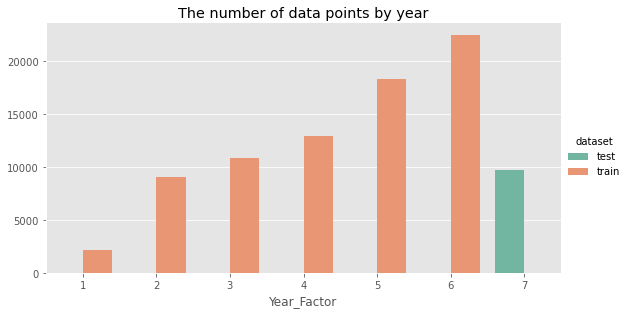

In [14]:
#The dataset contains time variable, Year_Factor, that has values from 1 to 7.
# Assuming the values are consecutive years,train dataset contains the first 6 years and test set contains the 7th year.
ax = sns.catplot(x='Year_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 kind='bar',
                 aspect=2,
                 height=4)\
.set(title="The number of data points by year",
     ylabel=None)

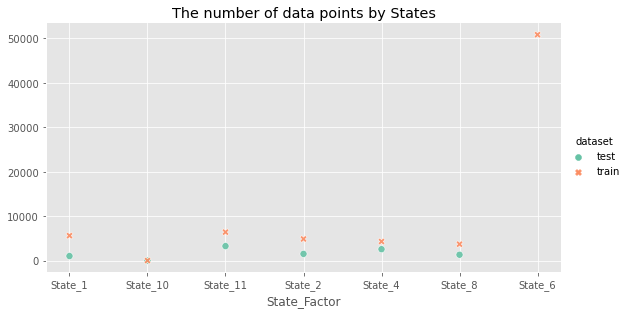

In [15]:
# train set contains data points of 7 states, however, test doesn't have any data point from State_6.
ax = sns.relplot(x='State_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=2,
                 height=4,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by States",
    ylabel=None)

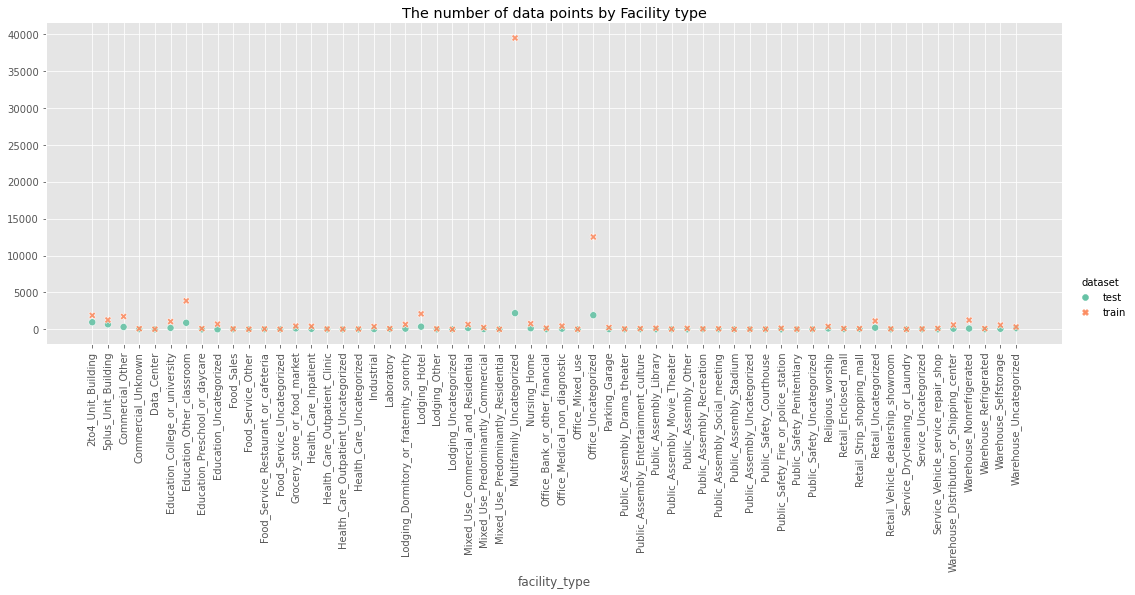

In [16]:
# All facility types are present in both datasets. 
# Almost 90% of residential Multifamily_uncategorized buildings and 50% of Office_uncategorized are in State_6 of the training set.
ax = sns.relplot(x='facility_type', 
                 y='id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by Facility type",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

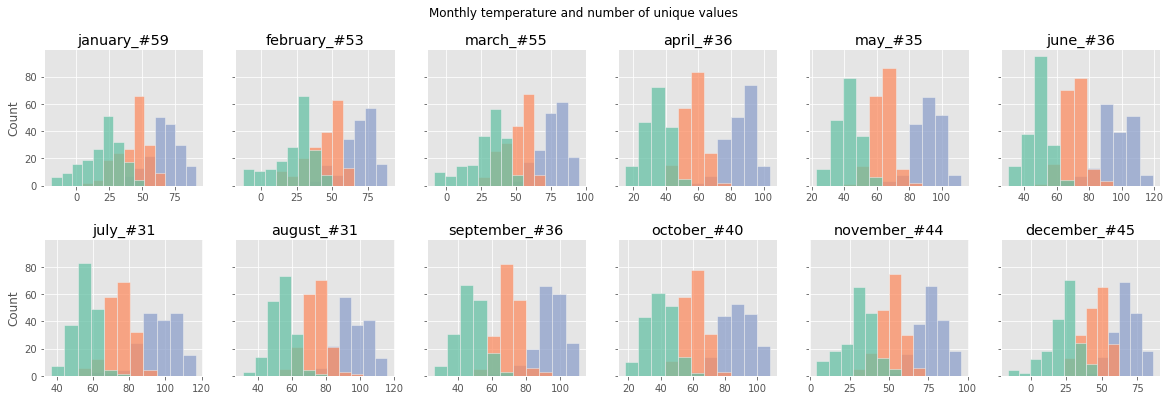

In [17]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]
        
fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

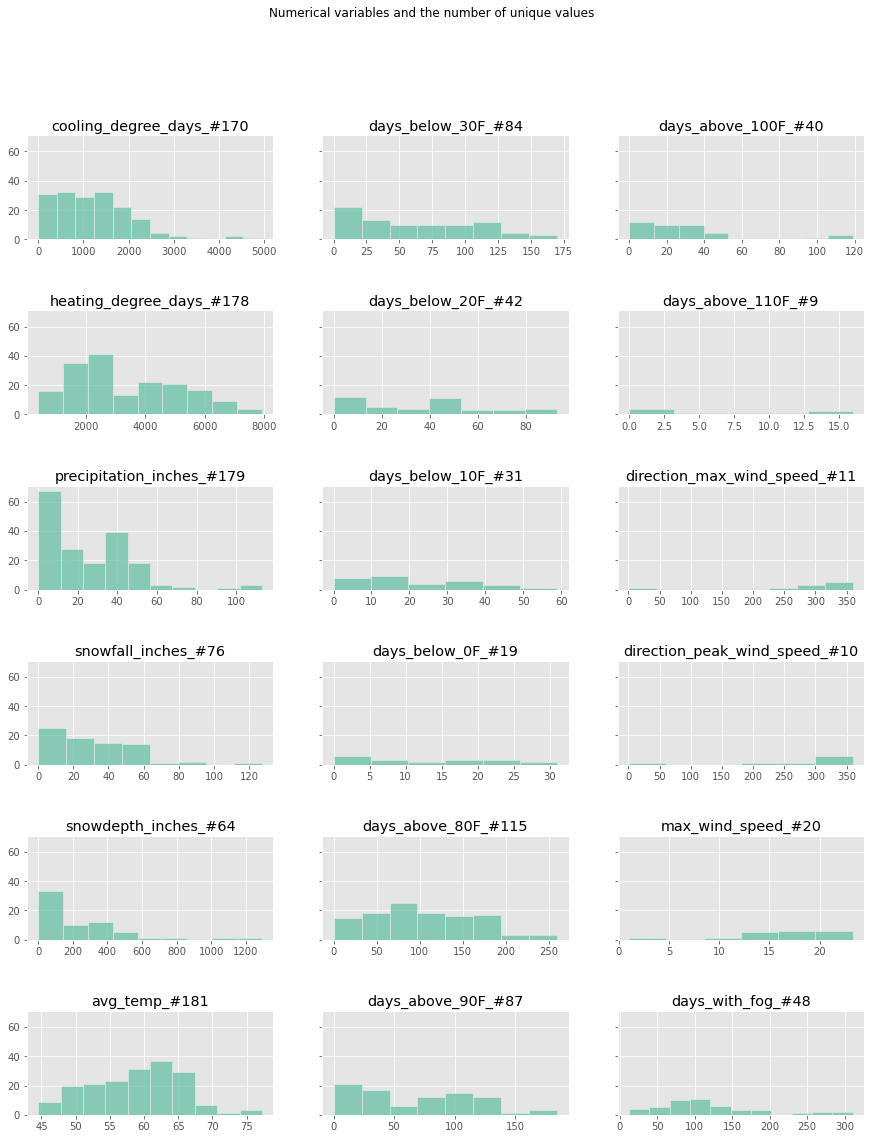

In [18]:
cols=['cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

fig, ax = plt.subplots(6,3, figsize=(15,18), sharey=True)
fig.suptitle("Numerical variables and the number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e,0], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    elif (e>=6) & (e<=11):
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-6,1], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-12,2], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
        
plt.subplots_adjust(hspace=0.7)

### Exploring Target variable (site_eui)

Text(0.5, 0, 'Target Histogram')

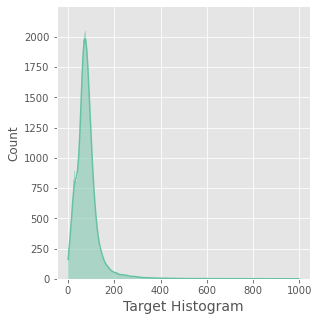

In [19]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=df_all['site_eui'], kde=True, palette='Set2')
ax1.set_xlabel('Target Histogram', fontsize=14)
# ax2 = plt.subplot(1,2,2)
# sns.boxplot(y=df_all['site_eui'], palette='Set2')
# ax2.set_xlabel('Target boxplot', fontsize=14)
# plt.tight_layout();

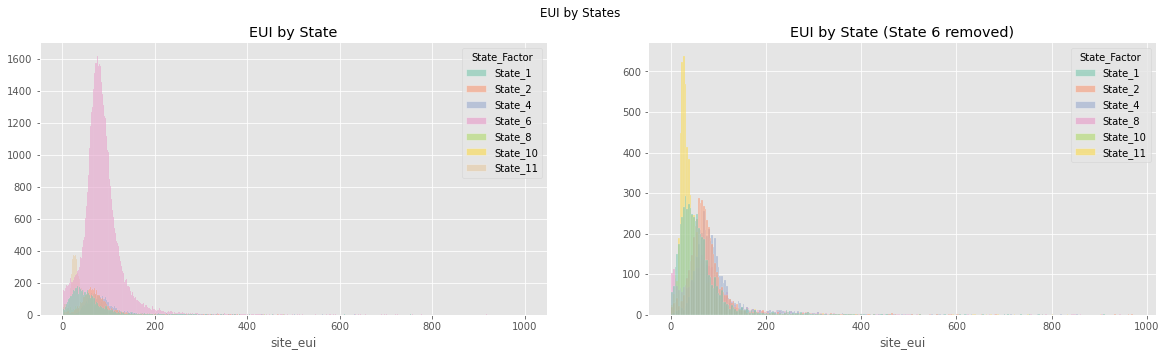

In [20]:

fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("EUI by States")

sns.histplot(df_all, x='site_eui',hue='State_Factor', ax=ax[0])\
.set(title='EUI by State', ylabel=None)

sns.histplot(df_all[df_all['State_Factor']!='State_6'], x='site_eui', hue='State_Factor', ax=ax[1])\
.set(title='EUI by State (State 6 removed)', ylabel=None);

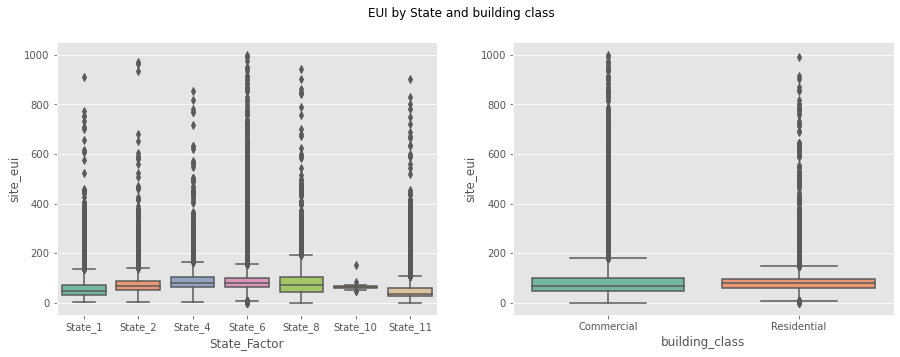

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUI by State and building class")

sns.boxplot(data=df_all, y='site_eui', x='State_Factor', ax=ax[0])
sns.boxplot(data=df_all, y='site_eui', x='building_class', ax=ax[1]);

Labs and Data Centers have higher EUI compared to the other types of buildings. Grocery stores, Health Care Inpatient, Health Care Uncategorized, Health Care Outpatient, and Food service, restaurants have higher range of EUI. It could be the essential services must operate for longer hours, therefore, have higher EUI.

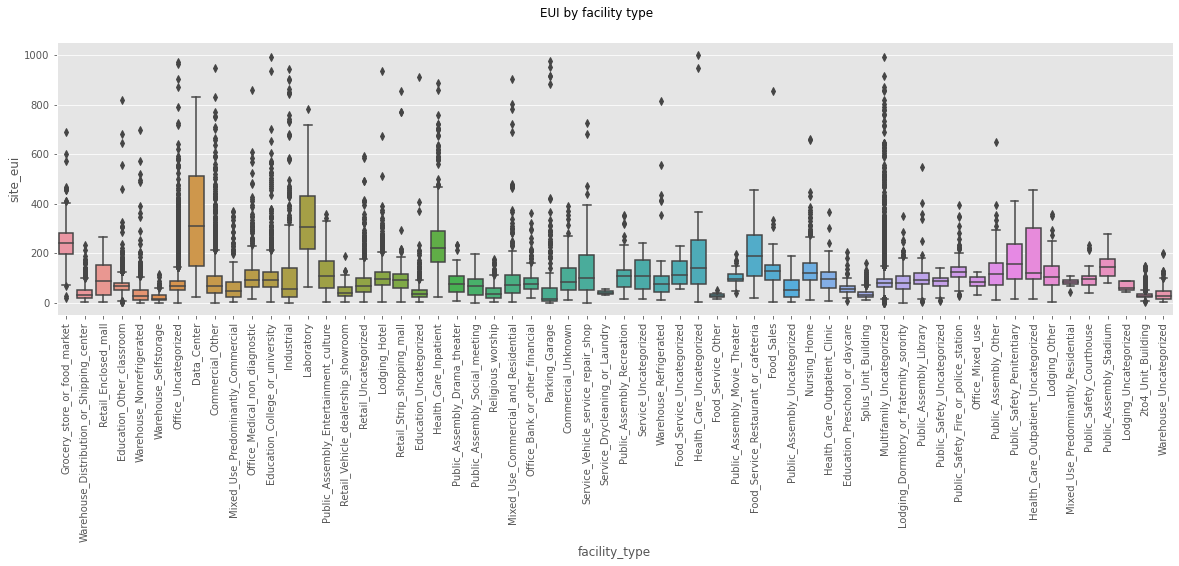

In [22]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

The most data points are in lower number of cooling_degree_days and higher number ofheating_degree_days. The majority of the datapoints are also in the lower levels of snowfall_inches and snowdepth_inches. direction_max_wind_speed, direction_peak_wind_speed. No relationship between EUI and the weather related numerica columns can be observed from the plot.

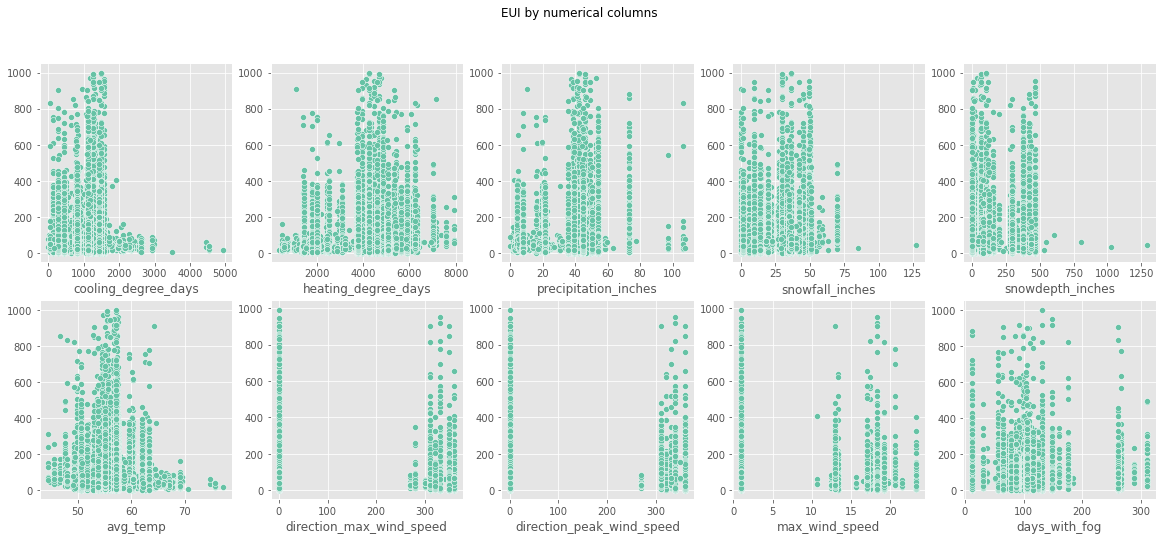

In [23]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches', 
      'snowfall_inches','snowdepth_inches'], 
      ['avg_temp', 
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 
      'days_with_fog']]

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')

for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=df_all, 
                        x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None);

Observations
- Categorical variables such as State_Factor, building_class and facility_type might have some correlation with EUI.
- State_6 is not present in test set. State 6 removed training data should be tested.
- floor_area, energe_star_rating should be included in the modelling to be tested.
- From the plots, it's difficult to observe direct (linear) relationship between EUI and weather related variables. However, this doesn't deny non-linear relationships among the variables.
Variables with more than 50% NA values should not be imputed (in my opinion) and better to be not included in the training set.

## Preprocessing

In [24]:
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
df_all = df_all.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)

In [25]:
df_all.loc[:,df_all.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

In [26]:
# This takes 1 hr, hence, unpickle the df1 and carry on with knn_imputing = False
knn_imputing = True
target='site_eui'

if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df = df_all.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    
    tmp.to_csv('imputer_tmp.csv', index=False)
    df1.to_csv('imputer_df1.csv', index=False)
    joblib.dump(imputer, 'knn_imputer.pkl')

else:
    df1 = pd.read_csv('imputer_df1.csv')
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df_all = df_all.drop(tmp.columns, axis=1)
    
    for col in tmp.columns:
        df_all[col]=tmp[col]
    for col in df1.columns:
        df_all[col] = df1[col]

Target encoding for categorical columns.
Target encoding is the process of replacing a categorical value with the mean of the target variable. Any non-categorical columns are automatically dropped by the target encoder model.

Note: You can also use target encoding to convert categorical columns to numeric.

“features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.”

In [27]:
# Null imputation for categorical values: KNN Imputing
cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all[f'te_{col}'] = encoder.fit_transform(df_all[col], df_all[target])

## Feature Engineering

In [28]:
# extract new weather statistics from the building location weather features
temp = [col for col in df_all.columns if 'temp' in col]

df_all['min_temp'] = df_all[temp].min(axis=1)
df_all['max_temp'] = df_all[temp].max(axis=1)
df_all['avg_temp'] = df_all[temp].mean(axis=1)
df_all['std_temp'] = df_all[temp].std(axis=1)
df_all['skew_temp'] = df_all[temp].skew(axis=1)


# by seasons
temp = pd.Series([col for col in df_all.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
df_all['min_winter_temp'] = df_all[winter_temp].min(axis=1)
df_all['max_winter_temp'] = df_all[winter_temp].max(axis=1)
df_all['avg_winter_temp'] = df_all[winter_temp].mean(axis=1)
df_all['std_winter_temp'] = df_all[winter_temp].std(axis=1)
df_all['skew_winter_temp'] = df_all[winter_temp].skew(axis=1)
### spring
df_all['min_spring_temp'] = df_all[spring_temp].min(axis=1)
df_all['max_spring_temp'] = df_all[spring_temp].max(axis=1)
df_all['avg_spring_temp'] = df_all[spring_temp].mean(axis=1)
df_all['std_spring_temp'] = df_all[spring_temp].std(axis=1)
df_all['skew_spring_temp'] = df_all[spring_temp].skew(axis=1)
### summer
df_all['min_summer_temp'] = df_all[summer_temp].min(axis=1)
df_all['max_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['avg_summer_temp'] = df_all[summer_temp].mean(axis=1)
df_all['std_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['skew_summer_temp'] = df_all[summer_temp].max(axis=1)
## autumn
df_all['min_autumn_temp'] = df_all[autumn_temp].min(axis=1)
df_all['max_autumn_temp'] = df_all[autumn_temp].max(axis=1)
df_all['avg_autumn_temp'] = df_all[autumn_temp].mean(axis=1)
df_all['std_autumn_temp'] = df_all[autumn_temp].std(axis=1)
df_all['skew_autumn_temp'] = df_all[autumn_temp].skew(axis=1)

## Checking target variable transformation

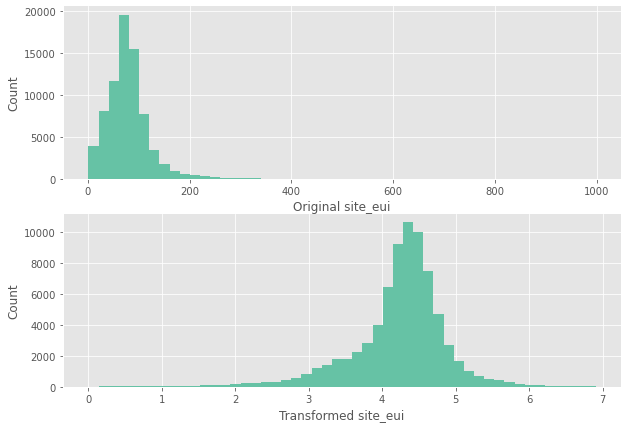

In [29]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

#### Checking skewness 

In [30]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F    89.873857
days_above_100F    24.615438
year_built        -11.706906
floor_area          6.701786
ELEVATION           5.140444
dtype: float64

In [31]:
#Treating skewness
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    
    # map the variable values into 0 and 1
    df_all[var] = np.where(df_all[var]==0, 0, 1)

## Saving feature dataset

In [32]:
df_all.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset,te_State_Factor,te_building_class,te_facility_type,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp
0,3,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,45.7,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90,45,65.129032,91,52,70.016667,104,52,71.387097,102,54,71.322581,97,47,69.133333,98,43,61.000000,84,36,55.116667,77,24,45.387097,68,826,2542,4.50,0.0,0,61.816451,20,0,0,0,111,31,1,0,NaN,NaN,NaN,NaN,6.800000,1456,train,62.196194,85.755239,92.642037,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253
1,4,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,55,68.661290,95,46,59.650000,76,41,56.790323,68,497,1477,20.69,0.0,0,64.197549,0,0,0,0,27,6,0,0,NaN,NaN,NaN,NaN,8.200000,2673,train,62.196194,85.755239,92.642037,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753
2,5,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,49,69.580645,96,29,52.866667,75,28,48.580645,68,1319,1823,7.95,0.0,0,65.453067,4,0,0,0,136,52,1,0,NaN,NaN,NaN,NaN,12.300000,3769,train,62.196194,85.755239,92.642037,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329
3,7,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,62.281685,0,0,0,0,29,5,1,0,NaN,NaN,NaN,NaN,NaN,76077,test,62.196194,85.755239,92.642037,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927
4,3,State_1,Commercial,Commercial_Other,10755.0,1937.0,NaN,9.1,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,35,56.967742,85,31,52.516667,76,16,43.338710,68,303,3108,4.16,0.0,0,58.126280,33,2,0,0,72,10,0,0,NaN,NaN,NaN,NaN,63.083288,2144,train,62.196194,85.755239,92.642037,1

In [33]:
saved = True
if saved:
#     !pip install pickle5 --quiet
#     import pickle5 as pickle
    data_path = 'feature_transformed_set.pkl'
    with open(data_path, "rb") as fh:
        df = joblib.load(fh)
else:
    df_all.to_pickle('feature_transformed_set.pkl')

In [34]:
train = df_all[df_all['dataset']=='train']
test = df_all[df_all['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui'] #y_train

train = train.drop(['id', 'dataset', 'site_eui'], axis=1) #X_train
test = test.drop(['id', 'dataset', 'site_eui'], axis=1) #X_test

### Label Encoding discrete features

In [35]:
# get discrete end categorical features colums indexes 
# needed later for model
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]
# create the label
le = LabelEncoder()
for col_idx in cats_discrete_idx:
    train.iloc[:, col_idx] = le.fit_transform(train.iloc[:, col_idx].astype(str))
    test.iloc[:, col_idx] = le.transform(test.iloc[:, col_idx].astype(str))

ValueError: y contains previously unseen labels: '7'

In [ ]:
print("Label Encoded Columns:")
for i in cats_discrete_idx:
    print(train.columns[i])

Label Encoded Columns:
Year_Factor
State_Factor
building_class
facility_type
january_min_temp
january_max_temp
february_min_temp
february_max_temp
march_min_temp
march_max_temp
april_min_temp
april_max_temp
may_min_temp
may_max_temp
june_min_temp
june_max_temp
july_min_temp
july_max_temp
august_min_temp
august_max_temp
september_min_temp
september_max_temp
october_min_temp
october_max_temp
november_min_temp
november_max_temp
december_min_temp
december_max_temp
cooling_degree_days
heating_degree_days
snowdepth_inches
days_below_30F
days_below_20F
days_below_10F
days_below_0F
days_above_80F
days_above_90F
days_above_100F
days_above_110F


In [ ]:
y_test = pd.read_csv('E:/TMLC/Projects/Site_Eui_PRJ_2/Dataset/y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 89)
Test: (9705, 89)
Samples:  (75757,)
Targets:  (9705,)


### Baseline modelling

##### CatBoost Regressor

In [ ]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)

In [ ]:
catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(X_test)

0:	learn: 57.8441196	test: 61.1897594	best: 61.1897594 (0)	total: 2.68s	remaining: 22m 17s
75:	learn: 44.6299105	test: 68.8048353	best: 61.1897594 (0)	total: 3m 55s	remaining: 21m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 61.18975944
bestIteration = 0

Shrink model to first 1 iterations.


In [ ]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 61.18975946483405
 MAE: 40.276753686525026
 MSE: 3744.186663364248
 R2: -0.035542204999772675


##### XGB Regressor

In [ ]:
xgb = XGBRegressor(n_estimators=400, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

NameError: name 'X_train' is not defined

In [ ]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

##### Random Forest

In [ ]:
rf = RandomForestRegressor(random_state=1, criterion='mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [ ]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

## Model Evaluation

In [ ]:
error_rec = {
    "catboost": {
        "mae": 40.31158275488301,
        "rmse": 61.22260709514953,
    },
    "randomforest": {
        "mae": 54.28693920734299,
        "rmse": 82.59775040932152,
    },
    "xgboost": {
        "mae": 54.28693920734299,
        "rmse": 82.59775040932152,
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2],
                 sns.color_palette("pastel")[3]]);

## Hyperparameter Tuning

In [ ]:
# Using cross validation
def k_fold_cv(x,y,fold=5):
    score_cb = cross_val_score(CatBoostRegressor(), x, y, cv=fold)
    
    scores = [score_cb]
    model_names = ['CatBoostRegressor']
    result = []
    
    for i in range(len(model_names)):
        scores_mean = np.mean(scores)
        scores_std = np.std(scores)
        m_names = model_names[i]
        temp = [scores_mean, scores_std, m_names]
        result.append(temp)
        
        k_fold_df = pd.DataFrame(result, columns= ['model_names', 'scores_mean', 'scores_std'])
        return k_fold_df.sort_values('scores_mean', ascending= False)

In [ ]:
# prepaere the out of folds predictions 
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits=5, shuffle=True, random_state=0)


for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = model.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += model.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))


## Final Evaluation

In [ ]:
y_cat_tuned = catb.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

## Saving Models

In [ ]:
with open('catb_best_final.joblib', 'wb') as f:
    joblib.dump(catb,f,compress=3)

In [ ]:
## Load models here
load = False
if load:
    with open('model/catb_best_final.joblib', 'rb') as f:
        catb = joblib.load(f)

### Explainable AI
pick your sample to study the model upon

In [ ]:
size = 2000

sample_exists = False

if sample_exists:
    sample_set = pd.read_csv('shap/sample2000.csv')
else:
    sample_set = X_test.sample(2000)
sample_set

In [ ]:
# calculate shap values
is_saved = False

if is_saved:
    with open(shap/shap_values_sample2000.pkl', 'rb') as f:
        shap_values = joblib.load(f)
else:
    shap_values = shap.TreeExplainer(model).shap_values(sample_set)

In [ ]:
shap.initjs()

In [ ]:
shap.summary_plot(shap_values, sample_set, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, sample_set)


In [ ]:
shap.dependence_plot('energy_star_rating', shap_values, sample_set)

In [ ]:
shap.dependence_plot('State_Factor', shap_values, sample_set)

In [ ]:
row = 111
shap.plots._waterfall.waterfall_legacy(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                                       shap_values[row],
                                       feature_names=sample_set.columns.tolist()
                                      )

In [ ]:
start = 120
limit = 130

shap.decision_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                   shap_values[start:limit], 
                   feature_names=sample_set.columns.tolist())